In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import warnings
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [3]:
def read_data():
    return pd.read_excel('../input/raw/AAPL_comp.xlsx')

def save_data(df, perc_):
    len_df = df.shape[0]
    train_perc = int(len_df * perc_)
    
    train_df = df[:train_perc]
    test_df = df[train_perc:]
    train_df.to_csv('../input/train.csv')
    test_df.to_csv('../input/test.csv')
    
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

data = read_data()
data = reduce_mem_usage(data)

Memory usage after optimization is: 9.06 MB
Decreased by 71.7%


In [9]:
# data['Date'] = pd.to_datetime(data['Date'])
df = data

In [19]:
# df['day'] = df['Date'].dt.day.astype("int16")
# df['month'] = df['Date'].dt.month.astype("int16")
# df['year'] = df['Date'].dt.year.astype("int16")
# df['weekday'] = df['Date'].dt.weekday.astype("int16")
# df['quarter'] = df['Date'].dt.quarter.astype("int16")
# # df['is_holiday'] = df['Date'].isin(holidays).astype("int16")

df['shifted_close'] = df['Close'].shift(periods=-1)
df.shifted_close.head()

0    30.625000
1    30.140625
2    30.078125
3    30.281250
4    30.015625
Name: shifted_close, dtype: float16

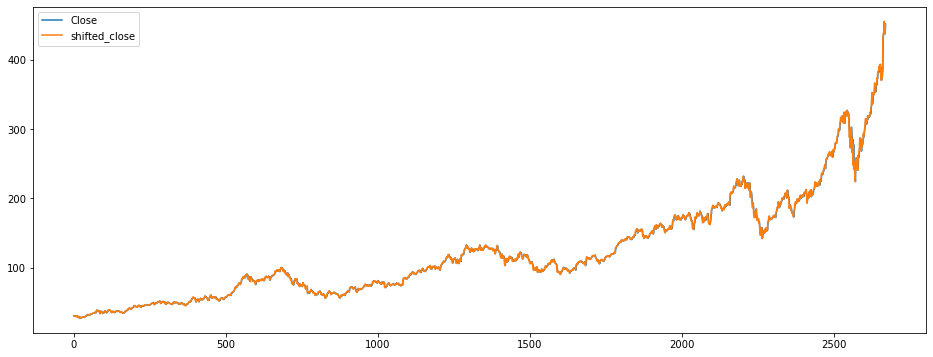

In [21]:
data[['Close', 'shifted_close']].plot(figsize=(16,6))

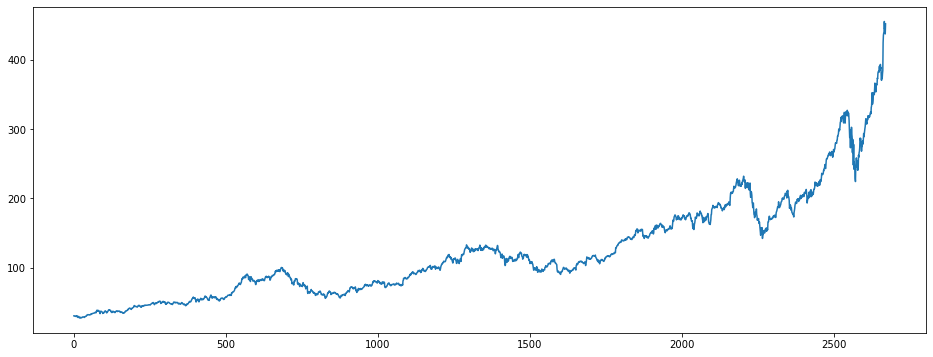

In [14]:
data['Close'].plot(figsize=(16,6))

In [22]:
def calc_roll_stats(s, windows=[5, 30]):
    '''
    # https://www.kaggle.com/hirayukis/lightgbm-keras-and-4-kfold
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        roll_stats['roll_mean_' + str(w)] = s.rolling(window=w, min_periods=1).mean()
        roll_stats['roll_std_' + str(w)] = s.rolling(window=w, min_periods=1).std()
        roll_stats['roll_min_' + str(w)] = s.rolling(window=w, min_periods=1).min()
        roll_stats['roll_max_' + str(w)] = s.rolling(window=w, min_periods=1).max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_mean_s_' + str(w)] = s.rolling(window=w, min_periods=1).mean().shift(-w)
        roll_stats['roll_std_s_' + str(w)] = s.rolling(window=w, min_periods=1).std().shift(-w)
        roll_stats['roll_min_s_' + str(w)] = s.rolling(window=w, min_periods=1).min().shift(-w)
        roll_stats['roll_max_s_' + str(w)] = s.rolling(window=w, min_periods=1).max().shift(-w)
        roll_stats['roll_range_s_' + str(w)] = roll_stats['roll_max_s_' + str(w)] - roll_stats['roll_min_s_' + str(w)]
        roll_stats['roll_min_abs_' + str(w)] = s.rolling(window=2*w, min_periods=1).min().abs().shift(-w)
        roll_stats['roll_range_sbs_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_abs_' + str(w)].shift(-w)
        roll_stats['roll_q10_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.10).shift(-w)
        roll_stats['roll_q25_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.25).shift(-w)
        roll_stats['roll_q50_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.50).shift(-w)
        roll_stats['roll_q75_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.75).shift(-w)
        roll_stats['roll_q90_' + str(w)] = s.rolling(window=2*w, min_periods=1).quantile(0.90).shift(-w)
        roll_stats['mean_abs_chg' + str(w)] = roll_stats.apply(lambda x: np.mean(np.abs(np.diff(x))))
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

#########################################################################################################################

def calc_ewm(s, windows=[5]):
    ewm = pd.DataFrame()
    for w in windows:
        ewm['ewm_mean_' + str(w)] = s.ewm(span=w, min_periods=1).mean()
        ewm['ewm_std_' + str(w)] = s.ewm(span=w, min_periods=1).std()
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [24]:
ewms = calc_ewm(data['Close'])
rollstats = calc_roll_stats(data['Close'])

In [27]:
df = data.join(ewms)
df = data.join(rollstats)

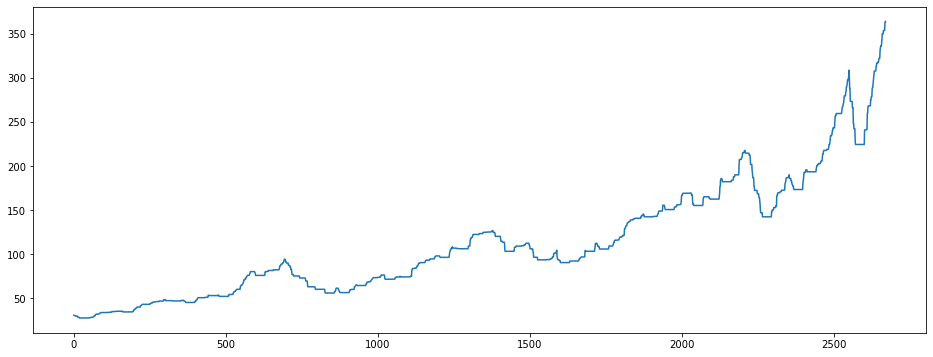

In [40]:
df['roll_min_30'].plot(figsize=(16,6))
# df.head()

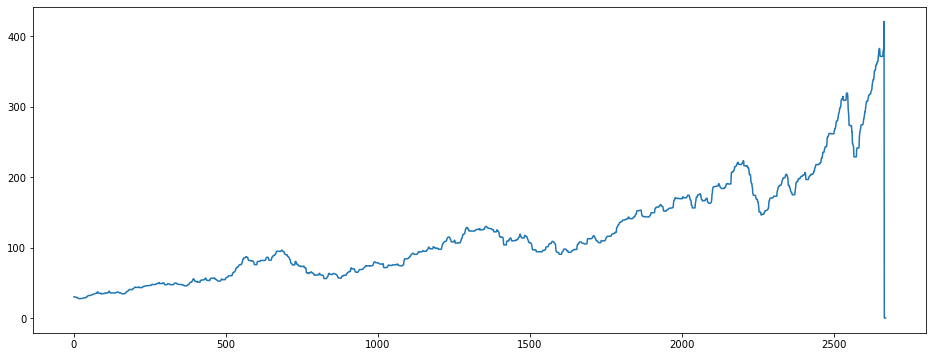

In [36]:
df['roll_q10_5'].plot(figsize=(16,6))

In [9]:
df['Date'] = pd.to_datetime(df['Date'])

# check if today is a holiday based on US
cal = calendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())

In [12]:
df.drop(['Date'], axis=1, inplace=True)

In [13]:
def return_class(x):
    if x<0:
        return 1 # fell
    elif x==0:
        return 2 # stagnant
    else:
        return 3 # rise

df['return_class'] = df['return'].apply(return_class)
df['return_class'].head()

0    1
1    1
2    1
3    3
4    1
Name: return_class, dtype: int64

In [14]:
df.head()

,Open,High,Low,Close,Volume,Currency,rsi,weekday,middle_bb,lower_bb,...,roll_q50_5,roll_q75_5,roll_q90_5,mean_abs_chg5,day,year,quarter,is_holiday,shifted_change,return_class
0,30.484375,30.640625,30.343750,30.562500,123432176,USD,75.3750,0,28.578125,26.28125,...,-0.006323,-0.002139,0.003505,0.0,4,2010,1,0,NaN,1
1,30.656250,30.796875,30.453125,30.625000,150476160,USD,74.0625,1,28.734375,26.31250,...,-0.005619,0.003505,0.010045,0.0,5,2010,1,0,-0.000978,1
2,30.625000,30.750000,30.109375,30.140625,138039728,USD,72.8125,2,28.890625,26.53125,...,-0.004475,0.001263,0.009531,0.0,6,2010,1,0,-0.015991,1
3,30.250000,30.296875,29.859375,30.078125,119282440,USD,71.3750,3,29.031250,26.78125,...,-0.003330,-0.000978,0.009016,0.0,7,2010,1,0,-0.005619,3
4,30.046875,30.296875,29.875000,30.281250,111969192,USD,79.0000,4,29.140625,26.84375,...,-0.003330,0.005746,0.015043,0.0,8,2010,1,0,0.007988,1


In [ ]:
save_data(df, 0.85)

### Feature Engineering

1. shift price features

In [17]:
# colscorr = ['Open', 'High', 'Low', 'Close', 'Volume', 'rsi', 'weekday', 'middle_bb',
#         'lower_bb', 'upper_bb', 'macd', 'pos_directional_indicator', 'neg_directional_indicator',
#         'adx', 'cci', 'aroon_down', 'aroon_up', 'aroon_indicator', 'day', 'month', 'year',
#         'quarter', 'is_holiday', 'return']

cor = df.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [22]:
#Correlation with output variable
# cor_target = abs(cor["return_class"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
relevant_features

mentions_pos_3_changeUSA_FSM     0.145972
mentions_pos_7_changeUSA_FSM     0.139685
mentions_neg_3_changeUSA_FSM     0.144196
articles_pos_3_changeUSA_FSM     0.145972
articles_pos_7_changeUSA_FSM     0.139685
articles_neg_3_changeUSA_FSM     0.144196
mentions_negUsA_KIR              0.106807
articles_negUsA_KIR              0.106807
mentions_pos_30UsA_KIR           0.101870
mentions_neg_30UsA_KIR           0.146626
articles_pos_30UsA_KIR           0.101870
articles_neg_30UsA_KIR           0.146626
mentions_pos_7_changeUsA_KIR     0.228097
mentions_neg_30_changeUsA_KIR    0.114592
articles_pos_7_changeUsA_KIR     0.228097
articles_neg_30_changeUsA_KIR    0.114592
mentions_neg_3_changeUSA_UGA     0.135408
articles_neg_3_changeUSA_UGA     0.135408
return                           0.740900
roll_mean_5                      0.354404
roll_min_5                       0.165978
roll_max_5                       0.150907
roll_min_abs_5                   0.105994
roll_range_sbs_5                 0

**Return class of price the following day, 1 - fell, 2-stagnant, 3-rise**

In [31]:
data['Close'].diff(periods=1) > 0

0       False
1        True
2       False
3       False
4        True
        ...  
2667     True
2668    False
2669     True
2670    False
2671     True
Name: Close, Length: 2672, dtype: bool

In [35]:
def get_feature_trend(ft):
    tmp_df = list(data[ft].diff(periods=1))
    ans = []
    for x in tmp_df:
        if x < 0:
            ans.append(1)
        elif x == 0:
            ans.append(2)
        else:
            ans.append(3)
    return ans

In [37]:
df['Close_trend'] = get_feature_trend('Close')
df['Close_trend']

0       3
1       3
2       1
3       1
4       3
       ..
2667    3
2668    1
2669    3
2670    1
2671    3
Name: Close_trend, Length: 2672, dtype: int64